<a href="https://colab.research.google.com/github/cpyp-ipdp/pgd_cdmx/blob/main/indicadores/pueblos_indigenas/indicadores_pueblos_indigenas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Estimación de indicadores de población indígena en la Ciudad de México
#Se borra todo lo que se encuentra en el entorno

rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, showtext, srvyr, haven, googledrive)

Loading required package: pacman

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pacman’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sysfonts’, ‘showtextdb’



showtext installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘numDeriv’, ‘mitools’, ‘RcppArmadillo’, ‘survey’



srvyr installed



In [2]:
#Crear directorio para guardar los archivos
dir.create("data", showWarnings = FALSE)

In [3]:
url_basica<-"https://www.inegi.org.mx/contenidos/programas/enigh/nc/"
segunda_parte<-"microdatos/enigh"
fin1<-"_ns_"
fin2<-"_csv.zip"

In [4]:
years<-c("2016", "2018", "2020", "2022")

In [5]:
# Función genérica para descargar, descomprimir, renombrar y eliminar
procesar_archivo <- function(year, tipo, url_base, segunda_parte, fin1, fin2, carpeta_destino) {
  # Construir URL y ruta de destino
  url <- paste0(url_base, year, "/", segunda_parte, year, fin1, tipo, fin2)
  destfile <- paste0(carpeta_destino, "/", year, fin1, tipo, fin2)

  # Descargar el archivo
  download.file(url, destfile = destfile)

  # Descomprimir el archivo
  unzip(destfile, exdir = carpeta_destino)

  # Renombrar el archivo descomprimido
  file.rename(
    from = paste0(carpeta_destino, "/", tipo, ".csv"),
    to = paste0(carpeta_destino, "/", tipo, "_", year, ".csv")
  )

  # Eliminar el archivo descargado
  file.remove(destfile)
}

In [6]:
# Iterar sobre los años y procesar cada tipo de archivo
for (i in 1:length(years)) {
  procesar_archivo(years[i], "poblacion", url_basica, segunda_parte, fin1, fin2, "data")
  procesar_archivo(years[i], "viviendas", url_basica, segunda_parte, fin1, fin2, "data")
  procesar_archivo(years[i], "trabajos", url_basica, segunda_parte, fin1, fin2, "data")
}

### Función de estimación

In [7]:
estimacion <- function(path, variable) {
  # Cargar los datos de población
  datos <- read_csv(path, show_col_types = FALSE)

  # Si son datos de 2016 a 2020, unir con la tabla de viviendas
  if (substr(path, 16, 19) %in% c("2016", "2018", "2020")) {
    # Cargar tabla viviendas
    vivienda <- read_csv(str_replace(path, "poblacion", "viviendas"), show_col_types = FALSE)

    # Pegar factor, upm y est_dis de la tabla vivienda
    datos <- datos %>%
      left_join(vivienda %>% select(folioviv, factor, upm, est_dis), by = "folioviv")
  }

  # Unir con la tabla trabajos si es "ocupacion" o si la persona debe ser identificada como indígena
  if (variable %in% c("ocupacion", "ocupacion_mujer")) {
    # Cargar tabla trabajos
    trabajos <- read_csv(str_replace(path, "poblacion", "trabajos"), show_col_types = FALSE)

    # Pegar datos relevantes de la tabla trabajos
    datos <- datos %>%
      left_join(trabajos %>% select(folioviv, foliohog, numren, id_trabajo, trapais),
                by = c("folioviv", "foliohog", "numren"))
  }

  # Crear variable cve_ent
  datos <- datos %>%
    mutate(cve_ent = case_when(
      nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
      nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    )) %>%
    # Filtrar si entidad es CDMX (09)
    filter(cve_ent == "09")

  # Definir diseño muestral
  mydesign <- datos %>%
    as_survey_design(ids = upm,
                     strata = est_dis,
                     weights = factor)

  # Estimar población hablante indígena en CDMX
  if (variable == "hablante") {
    hablante <- mydesign %>%
      group_by(hablaind) %>%
      summarise(
        poblacion = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = round(porcentaje * 100, 2)) %>%
      # Añadir año
      mutate(year = substr(path, 16, 19)) %>%
      filter(hablaind == 1)

    return(hablante)
  }

    # Estimar población hablante indígena en CDMX
  if (variable == "indigena") {
    indigena <- mydesign %>%
      group_by(etnia) %>%
      summarise(
        poblacion = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = round(porcentaje * 100, 2)) %>%
      # Añadir año
      mutate(year = substr(path, 16, 19)) %>%
      filter(etnia == 1)

    return(indigena)
  }


  # Estimar población ocupada, considerando si la persona es indígena
  if (variable == "ocupacion") {
    ocupacion <- mydesign %>%
      group_by(trapais,etnia) %>%
      summarise(
        ocupados = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = round(porcentaje * 100, 2)) %>%
      # Añadir año
      mutate(year = substr(path, 16, 19)) %>%
      filter(trapais == 1)%>%
filter(etnia == 1)
    return(ocupacion)
  }



  # Estimar población ocupada, considerando si la persona es indígena
  if (variable == "ocupacion_mujer") {
    ocupacion_muj <- mydesign %>%
      filter(trapais==1)%>%
      group_by(etnia,sexo) %>%
      summarise(
        ocupados = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = round(porcentaje * 100, 2)) %>%
      # Añadir año
      mutate(year = substr(path, 16, 19)) %>%
        #Filtro población indígena
filter(etnia == 1) %>%
  #Filtro mujer
filter(sexo==2)
    return(ocupacion_muj)
  }





  # Estimar población analfabeta
  if (variable == "analfabetismo") {
    analfa <- mydesign %>%
      group_by(etnia,alfabetism) %>%
      summarise(
        analfabetas = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = round(porcentaje * 100, 2)) %>%
      # Añadir año
      mutate(year = substr(path, 16, 19)) %>%
filter(etnia == 1)%>%
filter(alfabetism == 2)
    return(analfa)
  }

}


#### Población hablante indígena en CDMX

In [8]:
tabla_hablante<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "hablante"
)
print("Población hablante de lengua indígena en la CDMX")
tabla_hablante

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


[1] "Población hablante de lengua indígena en la CDMX"


hablaind,poblacion,poblacion_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,129097,0.1508605,1.41,0.1505873,2016
1,127656,0.2158292,1.38,0.2139413,2018
1,154656,0.1536397,1.67,0.1530732,2020
1,134098,0.1518493,1.43,0.1521503,2022


#### Población autodescripción indígena en CDMX

In [9]:
tabla_indigena<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "indigena"
)
print("Porcentaje de población que se autodescribe como indígena en la CDMX")
tabla_indigena

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


[1] "Porcentaje de población que se autodescribe como indígena en la CDMX"


etnia,poblacion,poblacion_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1250855,0.08416010,13.65,0.08129632,2016
1,1368626,0.08241738,14.85,0.07840943,2018
1,1392732,0.06554796,15.04,0.06381047,2020
1,1103900,0.07699844,11.81,0.07609140,2022


#### Población ocupada indígena en CDMX

In [10]:
tabla_ocupacion<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "ocupacion"
)
print("Población que se autodescribe como indígena y que se encuentra ocupada en la CDMX")
tabla_ocupacion

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or mo

[1] "Población que se autodescribe como indígena y que se encuentra ocupada en la CDMX"


trapais,etnia,ocupados,ocupados_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,701096,0.08687768,15.24,0.08163274,2016
1,1,716466,0.08822712,15.83,0.08266348,2018
1,1,684724,0.06773705,16.27,0.06419507,2020
1,1,550736,0.08300888,11.86,0.08205935,2022


####   Población ocupada indígena mujer en CDMX

In [11]:
tabla_ocupacion_mujer<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "ocupacion_mujer"
)
print("Población que se autodescribe como indígena que es mujer y que se encuentra ocupada en la CDMX")
tabla_ocupacion_mujer

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or mo

[1] "Población que se autodescribe como indígena que es mujer y que se encuentra ocupada en la CDMX"


etnia,sexo,ocupados,ocupados_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2,308308,0.10074117,43.98,0.04794138,2016
1,2,321598,0.10590241,44.89,0.04630140,2018
1,2,311122,0.07667507,45.44,0.04340553,2020
1,2,229755,0.09928867,41.72,0.05397506,2022


####   Población analfabeta indígena en CDMX

In [12]:
tabla_analfabetismo<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "analfabetismo"
)
print("Población que se autodescribe como indígena y que es analfabeta en la CDMX")

tabla_analfabetismo

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“There was 1 warning in `dplyr::summarise()`.
ℹ In argument: `porcentaje = survey_prop(vartype = "cv")`.
ℹ In group 5: `etnia = NA` and `alfabetism = NA`.
Caused by warning:
! glm.fit: algorithm did not converge”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“There was 1 warning in `dplyr::summarise()`.
ℹ In argument: `porcentaje = survey_prop(vartype = "cv")`.
ℹ In group 5: `etnia = NA` and `alfabetism = NA`.
Caused by warning:
! glm.fit: algorithm di

[1] "Población que se autodescribe como indígena y que es analfabeta en la CDMX"


etnia,alfabetism,analfabetas,analfabetas_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2,76848,0.2047636,6.14,0.1804278,2016
1,2,100372,0.1583444,7.33,0.1251706,2018
1,2,91929,0.1348095,6.60,0.1153417,2020
1,2,63920,0.2065419,5.79,0.1828260,2022


### Calcular porcentaje de población indígena que se encuentra en situación de pobreza


Para esto, se utilizan las bases generadas por Evalúa CDMX. Es importante señalar que, por practicidad, se trabaja con el producto terminado, no obstante, se buscará en próximas fechas replicar dicha metodología utilizando R ya que actualmente, el programa de cálculo se encuentra en STATA.

In [13]:
  #Conectar a google drive
drive_auth(email = "cpyp.ipdp@gmail.com",cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=740ad3d6af0bc477cd15fb3baaa387a2&login_hint=cpyp.ipdp%40gmail.com&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQVNWZ2kzSmQtdGxORkZGZVpmaWhzYUVreUJXLWM5cl81US1GdEtzQ1NfRmpIZXYxT1ZubkxmNm9OWHZKb3pzWm5IWDNuQSIsInN0YXRlIjoiNzQwYWQzZDZhZjBiYzQ3N2NkMTVmYjNiYWFhMzg3YTIifQ==


In [14]:
carpeta<-as_id(drive_get("https://drive.google.com/drive/folders/1TBfoik4w4DWhwFqWeZFgkZvrBdDbqzku"))


archivos<-drive_ls(carpeta)
print(archivos)

# A dribble: 3 × 3
  name             id                                drive_resource   
  <chr>            <drv_id>                          <list>           
1 pobreza_2022.dta 1T_WfYanYMOoWWbhj_CeiqxYRNrpXmDan <named list [40]>
2 pobreza_2018.dta 1TTRfiRDGWgQwHylvduHx1IRdm5vQ3VeL <named list [40]>
3 pobreza_2020.dta 1TXJLNA_itWfjsGIdoj1bJQ4erNjc1wIx <named list [40]>


In [15]:
archivos[1]

name
<chr>
pobreza_2022.dta
pobreza_2018.dta
pobreza_2020.dta


In [16]:
estimacion_pobreza <- function(file_id, file_name) {
  # Descarga de datos
  local_path <- file.path("data", file_name)
  drive_download(as_id(file_id), path = local_path, overwrite = TRUE)

  # Leer datos
  datos <- read_dta(local_path)

  # Añadir año
  year <- str_extract(file_name, "\\d{4}")


  # Diseño muestral
  mydesign <- datos %>%
    as_survey_design(ids = upm,
                     strata = est_dis,
                     weights = factor)

  # Estima pobreza
  pobreza <- mydesign %>%
    #Filtrar datos para CDMX
  filter(entidad==9)%>%
    #Filtar grupo de población en pobreza
    #filter(pobreza_mmip == 1) %>%
    group_by(etnia,pobreza_mmip)%>%
    summarise(
      poblacion = survey_total(vartype = "cv"),
      porcentaje = survey_prop(vartype = "cv")
    ) %>%
    mutate(porcentaje = round(porcentaje * 100, 2),
           year = as.numeric(year))%>%
             #Filtro de población indígena
             filter(etnia==1)

  return(pobreza)
}


In [17]:
estimacion_pobreza_simple <- function(file_id, file_name) {
  # Descarga de datos
  local_path <- file.path("data", file_name)
  drive_download(as_id(file_id), path = local_path, overwrite = TRUE)

  # Leer datos
  datos <- read_dta(local_path)

  # Añadir año
  year <- str_extract(file_name, "\\d{4}") %>% as.numeric()

  # Filtrar datos para CDMX y población en pobreza
  pobreza <- datos %>%
    filter(entidad == 9) %>%
    group_by(etnia,pobreza_mmip) %>%
    summarise(
      observaciones = n(),  # Contar el número de observaciones
      porcentaje = (n() / nrow(datos)) * 100  # Calcular porcentaje sobre el total de la tabla
    ) %>%
    mutate(
      porcentaje = round(porcentaje, 2),
      year = year
    ) %>%
    # Filtro de población indígena
    filter(etnia == 1)%>%
      select(pobreza_mmip,observaciones,year)

  return(pobreza)
}


In [18]:
tabla_pobreza <- map_dfr(
  seq_len(nrow(archivos)),
  ~ estimacion_pobreza(archivos$id[.x], archivos$name[.x])
)%>%
  arrange(year)%>%
  filter(pobreza_mmip==1)

print("Estimación de población indígena en situación de pobreza en la CDMX")
tabla_pobreza

File downloaded:

• pobreza_2022.dta <id: 1T_WfYanYMOoWWbhj_CeiqxYRNrpXmDan>

Saved locally as:

• data/pobreza_2022.dta

File downloaded:

• pobreza_2018.dta <id: 1TTRfiRDGWgQwHylvduHx1IRdm5vQ3VeL>

Saved locally as:

• data/pobreza_2018.dta

File downloaded:

• pobreza_2020.dta <id: 1TXJLNA_itWfjsGIdoj1bJQ4erNjc1wIx>

Saved locally as:

• data/pobreza_2020.dta



[1] "Estimación de población indígena en situación de pobreza en la CDMX"


etnia,pobreza_mmip,poblacion,poblacion_cv,porcentaje,porcentaje_cv,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1011897,0.09435402,74.41,0.03664584,2018
1,1,921413,0.07989246,66.35,0.03980687,2020
1,1,816899,0.08744365,75.13,0.03089138,2022


In [19]:
tabla_pobreza_simple <- map_dfr(
  seq_len(nrow(archivos)),
  ~ estimacion_pobreza_simple(archivos$id[.x], archivos$name[.x])
)%>%
  arrange(year)%>%
  select(pobreza_mmip,observaciones,year)

print("Observaciones muestrales de población indígena y condición de pobreza en la CDMX")
tabla_pobreza_simple

File downloaded:

• pobreza_2022.dta <id: 1T_WfYanYMOoWWbhj_CeiqxYRNrpXmDan>

Saved locally as:

• data/pobreza_2022.dta

`summarise()` has grouped output by 'etnia'. You can override using the
`.groups` argument.
Adding missing grouping variables: `etnia`
File downloaded:

• pobreza_2018.dta <id: 1TTRfiRDGWgQwHylvduHx1IRdm5vQ3VeL>

Saved locally as:

• data/pobreza_2018.dta

`summarise()` has grouped output by 'etnia'. You can override using the
`.groups` argument.
Adding missing grouping variables: `etnia`
File downloaded:

• pobreza_2020.dta <id: 1TXJLNA_itWfjsGIdoj1bJQ4erNjc1wIx>

Saved locally as:

• data/pobreza_2020.dta

`summarise()` has grouped output by 'etnia'. You can override using the
`.groups` argument.
Adding missing grouping variables: `etnia`
Adding missing grouping variables: `etnia`


[1] "Observaciones muestrales de población indígena y condición de pobreza en la CDMX"


etnia,pobreza_mmip,observaciones,year
<chr>,<dbl>,<int>,<dbl>
1,0,253,2018
1,1,1064,2018
1,0,388,2020
1,1,1359,2020
1,0,235,2022
1,1,1019,2022


### Estimación de metas de población indígena analfabeta

In [20]:
#Tabla de analfabetismo
datos<-data.frame(tabla_analfabetismo$year,tabla_analfabetismo$porcentaje)%>%
    rename(year=tabla_analfabetismo.year,
             porcentaje=tabla_analfabetismo.porcentaje)%>%
mutate(year=as.numeric(year))
datos

year,porcentaje
<dbl>,<dbl>
2016,6.14
2018,7.33
2020,6.60
2022,5.79


In [21]:
##Calcular tasa de crecimiento promedio anual de 2016 a 2022

valor_inicial<-datos$porcentaje[1]
valor_final <- datos$porcentaje[length(datos$porcentaje)]
n <- datos$year[length(datos$year)] - datos$year[1]

tasa_crecimiento <- (valor_final / valor_inicial)^(1 / n) - 1
print("Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025")
tasa_crecimiento

[1] "Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025"


[1] -0.009734386

In [22]:
proyecciones <- data.frame(year = seq(2023, 2045, by = 1))
proyecciones$porcentaje <- valor_final * (1 + tasa_crecimiento)^(proyecciones$year - 2022)
proyecciones

year,porcentaje
<dbl>,<dbl>
2023,5.733638
2024,5.677824
2025,5.622554
2026,5.567822
2027,5.513623
2028,5.459951
2029,5.406802
2030,5.354170
2031,5.302050


In [23]:
datos_proyectados <- rbind(datos, proyecciones)

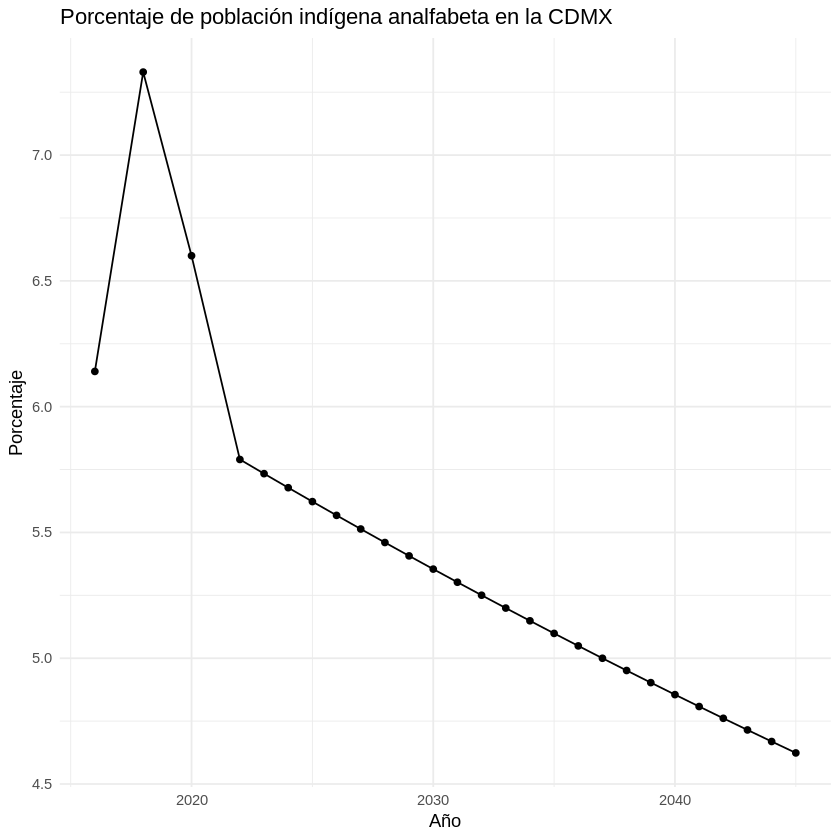

In [24]:
#Gráfica
ggplot(datos_proyectados, aes(x = year, y = porcentaje)) +
  geom_line() +
  geom_point() +
  labs(title = "Porcentaje de población indígena analfabeta en la CDMX",
       x = "Año",
       y = "Porcentaje") +
  theme_minimal()

In [25]:
#Datos 2030, 2035 y 2045
datos_proyectados %>% filter(year %in% c(2030, 2035, 2045))

year,porcentaje
<dbl>,<dbl>
2030,5.354170
2035,5.098597
2045,4.623466


**Estimación de metas de porcentaje de población indígena en situación de pobreza**
Se considera la tasa de creciemnto entre los años 2018 y 2020

[1] "Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025"


[1] -0.0282548

year,porcentaje
<dbl>,<dbl>
2023,64.47529
2024,62.65356
2025,60.88329
2026,59.16305
2027,57.49141
2028,55.86700
2029,54.28849
2030,52.75458
2031,51.26401


etnia,pobreza_mmip,poblacion,poblacion_cv,porcentaje,porcentaje_cv,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,52.75458,NA,2030
NA,NA,NA,NA,45.71116,NA,2035
NA,NA,NA,NA,34.31992,NA,2045


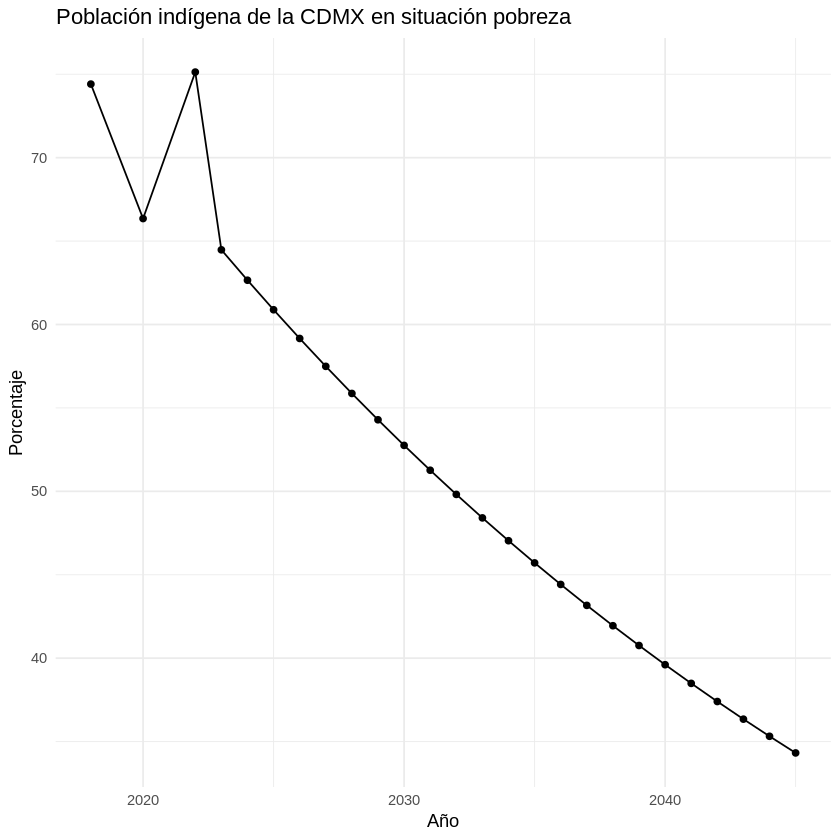

In [26]:
##Calcular tasa de crecimiento promedio anual de 2016 a 2022
valor_inicial<-tabla_pobreza$porcentaje[1]
valor_final <- tabla_pobreza$porcentaje[2]
n <- tabla_pobreza$year[length(tabla_pobreza$year)] - tabla_pobreza$year[1]

tasa_crecimiento_pobreza<- (valor_final / valor_inicial)^(1 / n) - 1
print("Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025")
tasa_crecimiento_pobreza

proyecciones_pobreza <- data.frame(year = seq(2023, 2045, by = 1))
proyecciones_pobreza$porcentaje <- valor_final * (1 + tasa_crecimiento_pobreza)^(proyecciones_pobreza$year - 2022)
proyecciones_pobreza

datos_proyectados_pobreza <- rbind(tabla_pobreza, proyecciones_pobreza)

#Gráfica
ggplot(datos_proyectados_pobreza, aes(x = year, y = porcentaje)) +
  geom_line() +
  geom_point() +
  labs(title = "Población indígena de la CDMX en situación pobreza",
       x = "Año",
       y = "Porcentaje") +
  theme_minimal()

#Datos 2030, 2035 y 2045
datos_proyectados_pobreza %>% filter(year %in% c(2030, 2035, 2045))